# W-14

In [1]:
from FMM_BEM import create_quad_tree_w_msh_file,upward_pass, downward_pass,evaluate_field_at_targets,solve_bem_system
import matplotlib.pyplot as plt
import numpy as np

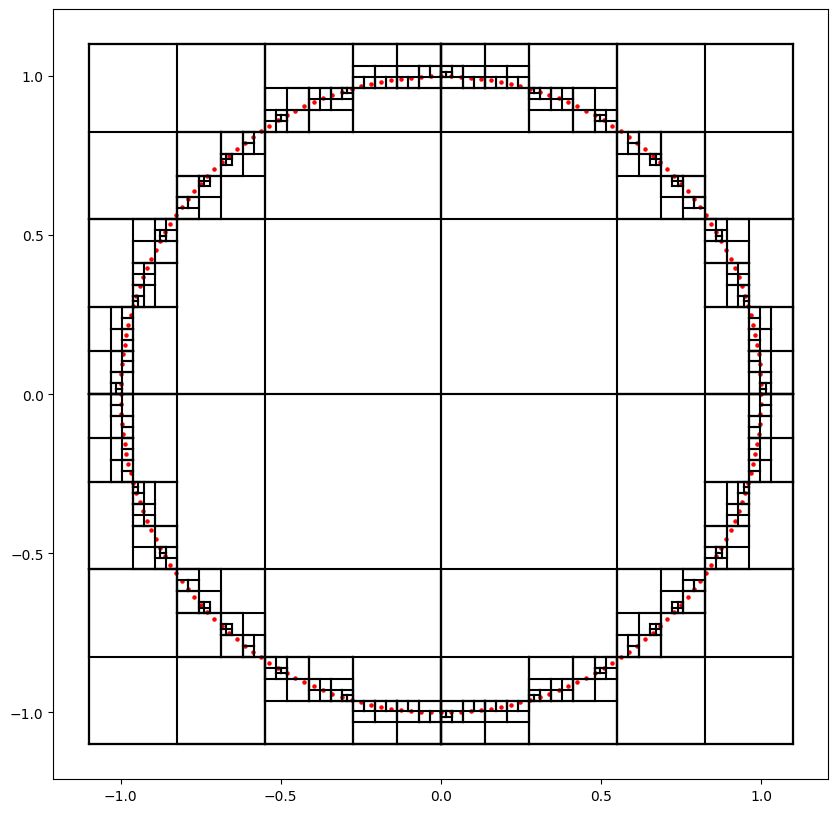

In [8]:
quadtree,boundary_points = create_quad_tree_w_msh_file("files\disk.msh",1,20)

def plot_quadtree(node, ax):
    """ Función recursiva para dibujar los límites del quadtree. """
    xmin, ymin, xmax, ymax = node.bounds
    ax.plot([xmin, xmax], [ymin, ymin], 'k-')
    ax.plot([xmin, xmax], [ymax, ymax], 'k-')
    ax.plot([xmin, xmin], [ymin, ymax], 'k-')
    ax.plot([xmax, xmax], [ymin, ymax], 'k-')

    for child in node.children:
        plot_quadtree(child, ax)

# Visualizar el quadtree
fig, ax = plt.subplots(figsize=(10,10))
plot_quadtree(quadtree, ax)
ax.scatter(boundary_points[:, 0], boundary_points[:, 1], color='red', s=5)  # Dibujar los puntos de la frontera
plt.show()

In [14]:
order = 3  # Orden de la expansión multipolar (sujeto a cambios)
upward_pass(quadtree, order=order)

array([ 2.00000000e+02+0.00000000e+00j,  5.76631876e-05+1.96734785e-07j,
        9.40246808e-04+1.68003734e-11j, -4.75201016e-16+3.07049443e-21j])

In [20]:
quadtree.children[0].children[0].local_expansion

array([ 4.89937605e+01-9.73460987e-04j, -1.34735518e+01-1.34730164e+01j,
        1.47235974e-04+7.41030628e+00j,  2.03779374e+00-2.03787472e+00j])

In [19]:
downward_pass(quadtree,order=order)

{<quadtree.Quadtree at 0x133bfe8b190>: {<quadtree.Quadtree at 0x133bfe896d0>: {<quadtree.Quadtree at 0x133bfea3210>: {<quadtree.Quadtree at 0x133bfea3210>: array([ 1.29889075e+01-0.08365387j,  1.77447237e+00-1.79747718j,
           -3.16316191e-03-0.49114306j, -6.79671060e-02-0.06709724j])},
   <quadtree.Quadtree at 0x133bfea30d0>: {<quadtree.Quadtree at 0x133bfea30d0>: array([ 1.30110012e+01-0.05221685j, -1.78183285e+00+1.79619248j,
           -1.97444966e-03-0.49197848j,  6.79185283e-02+0.06737555j])},
   <quadtree.Quadtree at 0x133bfea2110>: {<quadtree.Quadtree at 0x133bfe8e410>: {<quadtree.Quadtree at 0x133bfe8e410>: array([ 1.10485784e+01-0.0542317j , -7.63318196e-01-0.75586134j,
             5.12659037e-04+0.10444359j,  7.14525171e-03-0.00721574j])},
    <quadtree.Quadtree at 0x133bfe3d510>: {<quadtree.Quadtree at 0x133bfe3e1d0>: {<quadtree.Quadtree at 0x133bfe3e1d0>: array([ 5.01626676e+00-0.0210569j , -1.73158001e-01-0.17171034j,
              4.97633788e-05+0.01185485j,  4.057

In [6]:
print("Evaluando el campo en los puntos de la frontera...")
field_values = evaluate_field_at_targets(quadtree)

for point, value in field_values.items():
    print(f"Punto: {point}m valoir del campo {value}")

Evaluando el campo en los puntos de la frontera...
Punto: (np.float64(1.0), np.float64(0.0))m valoir del campo (1.9888002304040304+0.014635261071107901j)
Punto: (np.float64(0.0), np.float64(1.0))m valoir del campo (1.985544325061708+0.011178858925576777j)
Punto: (np.float64(-1.0), np.float64(0.0))m valoir del campo (2.010996730224844+0.014474136575518468j)
Punto: (np.float64(0.0), np.float64(-1.0))m valoir del campo (1.9855443250538507-0.011178859109370535j)
Punto: (np.float64(0.999506560363376), np.float64(0.03141075915308367))m valoir del campo (1.9854969204049167-0.011136426060358959j)
Punto: (np.float64(0.9980267284189905), np.float64(0.06279051967683048))m valoir del campo (2.982668904261322-0.011336779896977494j)
Punto: (np.float64(0.9955619645829901), np.float64(0.09410831353104387))m valoir del campo (2.0106376260728056-0.021565391572044745j)
Punto: (np.float64(0.9921147012781006), np.float64(0.1253332338522595))m valoir del campo (2.019930173472982+0.01123910144348661j)
Punto:

In [7]:
solve_bem_system(boundary_points=boundary_points,field_values=field_values)

Resolviendo el sistema con GMRES...


(array([ 8.54310707e+13-3.42515429e+11j,  8.55074782e+13-2.61409606e+11j,
         8.49102008e+13-3.38712616e+11j,  8.55075002e+13+2.63243657e+11j,
         8.55086126e+13+2.62247863e+11j,  6.21086605e+13+2.67929466e+11j,
         8.49186631e+13+5.07001966e+11j,  8.47005690e+13-2.62789481e+11j,
         8.49448104e+13+1.11699611e+11j,  8.50683624e+13-2.30574483e+11j,
         8.50452762e+13-3.95051500e+11j,  8.55355854e+13-1.19366493e+11j,
         8.48225190e+13-3.60000739e+10j,  8.51334656e+13+3.42151708e+11j,
         6.18315500e+13+2.78933609e+11j,  8.56940109e+13+1.03808260e+11j,
         8.46452845e+13-1.33434723e+11j,  1.56800465e+13+2.55142028e+11j,
         1.45991013e+13+8.62090366e+11j,  8.50274611e+13-3.60844751e+11j,
         8.55245358e+13-1.41415715e+11j,  6.16598892e+13+6.96406019e+10j,
        -1.62148879e+14+1.20945977e+12j,  8.48696047e+13-7.14295228e+11j,
         8.44676509e+13+3.00781799e+11j,  1.52375231e+13-2.13491759e+11j,
         8.50751822e+13-1.40269928e+11